# Testing Notebook

This notebook tests the active learning functionality of the developed GP package. In particular, we will train a GP model adaptively to capture the failure boundary (limit-state)

In [1]:
# Get path right
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\GaussianProcess")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyDOE import lhs
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Import GP interpolation module
from GPInterpolator import GPInterpolator

%matplotlib inline

# 1. Test Function (2D)

We select the following test function in this case study:

\begin{equation}
y(x_1, x_2) = 20-(x_1-x_2)^2-8(x_1+x_2-4)^3, \; x_1 \in [-6, 6], x_2 \in [-4, 6]
\end{equation}

The failure boundary is defined as $y(x_1, x_2) = 0$.

Later on, we will train a Gaussian Process model to capture the failure boundary. This is crucial for accurate and robust risk analysis. To minimize the number of employed training samples, we will use an active learning strategy to allocate new samples in the vicinity of the failure boundary. 

Let's first plot this function to gain some intuition.

In [2]:
def Test_2D(X):
    """2D Test Function"""
    y = 20 - (X[:,0]-X[:,1])**2 - 8*(X[:,0]+X[:,1]-4)**3
    return y

In [19]:
# Load LHS package
from pyDOE import lhs

# Test data
X1 = np.linspace(-6, 6, 100)
X2 = np.linspace(-4, 6, 100)
X1, X2 = np.meshgrid(X1, X2)
X_test = np.hstack((X1.reshape(-1,1), X2.reshape(-1,1)))
y_test = Test_2D(X_test)

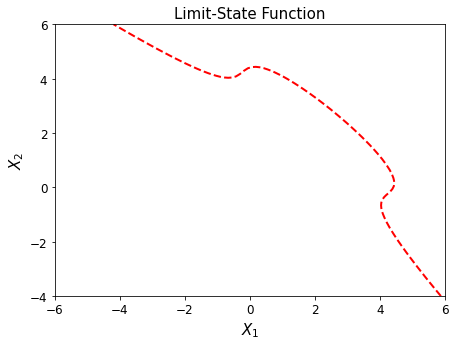

In [20]:
# Visualize the limit state function
fig, ax = plt.subplots(figsize=(7,5))
ax.contour(X_test[:,0].reshape(100,-1), 
               X_test[:,1].reshape(100,-1), 
               y_test.reshape(100,-1), levels = [0],
                 colors='r',linestyles='--',linewidths=2)
ax.set_xlabel(r'$X_1$', fontsize=15)
ax.set_ylabel(r'$X_2$', fontsize=15)
ax.set_title('Limit-State Function', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12);

In [102]:
# Generate training data
sample_num = 10
lb, ub = np.array([-6, -4]), np.array([6, 6])
X_train = (ub-lb)*lhs(2, samples=sample_num) + lb

# Compute labels
y_train = Test_2D(X_train).reshape(-1,1)

In [103]:
# GP model training
pipe = Pipeline([('scaler', MinMaxScaler()), 
         ('GP', GPInterpolator(n_restarts=30))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('GP',
                 <GPInterpolator.GPInterpolator object at 0x0000019D802F5160>)])

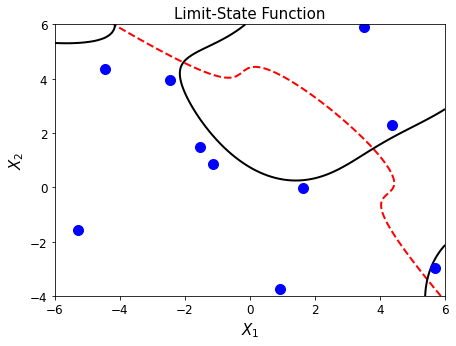

In [104]:
# GP model predicting
y_pred, y_pred_SSqr = pipe.predict(X_test)

# Post-processing - Contour plot
fig, ax = plt.subplots(figsize=(7,5))

# Reference results
ax.contour(X_test[:,0].reshape(100,-1), 
           X_test[:,1].reshape(100,-1), 
           y_test.reshape(100,-1), levels = [0],
           colors='r',linestyles='--',linewidths=2)

# GP predictions
ax.contour(X_test[:,0].reshape(100,-1), 
           X_test[:,1].reshape(100,-1), 
           y_pred.reshape(100,-1), levels = [0],
           colors='k',linestyles='-',linewidths=2)

ax.plot(X_train[:,0], X_train[:,1],'bo', 
        markerfacecolor='b', markersize=10)

ax.set_xlabel(r'$X_1$', fontsize=15)
ax.set_ylabel(r'$X_2$', fontsize=15)
ax.set_title('Limit-State Function', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12);

In [105]:
# Start active learning
iteration = 1
U_history = []

# Generate candidate samples
Candidate = (ub-lb)*lhs(2, 10000) + lb
Candidate_normalized = pipe['scaler'].transform(Candidate)

**The following two cells can be excuted multiple times to manually control the iteration flow**. The first cell identify the sample with the maximum prediction error. The second and third cell visually summarizes the results from the current iteration and add newly identified samples to the current training dataset.

In [170]:
# 1-GP model training and predicting
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)[0]

# 2-Active learning
target, index, U = pipe['GP'].enrichment('U', 
                                     candidate=Candidate_normalized, 
                                     diagnose=True)
U_history.append(target)

# 3-Display iteration info
summary = 'Iteration summary:'
iter_number = 'Current iteration: {}'.format(str(iteration))

Iteration_summary = 'Iteration {}:'.format(str(iteration)) \
                    + os.linesep \
                    + 'Current min U is {}'.format(str(target)) \
                    + os.linesep \
                    + 'Located at {}'.format(str(Candidate[index]))

print(Iteration_summary)

Iteration 33:
Current min U is 0.1541676141755046
Located at [4.22908225 0.06002074]


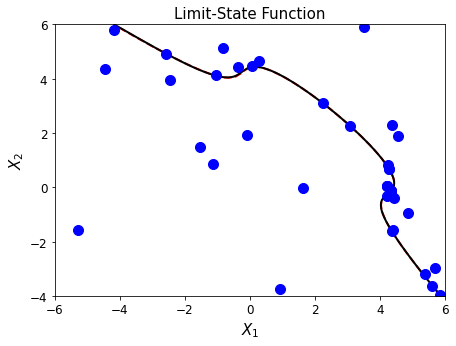

In [171]:
# 4-Iteration assessment
fig, ax = plt.subplots(figsize=(7,5))

# Reference results
ax.contour(X_test[:,0].reshape(100,-1), 
           X_test[:,1].reshape(100,-1), 
           y_test.reshape(100,-1), levels = [0],
           colors='r',linestyles='--',linewidths=2)

# GP predictions
ax.contour(X_test[:,0].reshape(100,-1), 
           X_test[:,1].reshape(100,-1), 
           y_pred.reshape(100,-1), levels = [0],
           colors='k',linestyles='-',linewidths=2)

ax.plot(X_train[:,0], X_train[:,1],'bo', 
        markerfacecolor='b', markersize=10)

ax.set_xlabel(r'$X_1$', fontsize=15)
ax.set_ylabel(r'$X_2$', fontsize=15)
ax.set_title('Limit-State Function', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12);

# 5-Enrich training dataset
X_train = np.vstack((X_train, Candidate[[index],:]))
y_train = np.vstack((y_train, Test_2D(Candidate[[index],:]).reshape(-1,1)))
iteration += 1

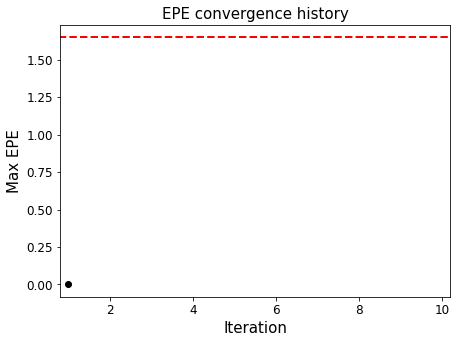

In [50]:
# EPE convergence history
fig, ax = plt.subplots(figsize=(7,5))

threshold = 1.65
ax.plot(np.arange(1,iteration), U_history, 'k-o', lw=2)
ax.plot([0, 15.3],[threshold, threshold],'r--',lw=2)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Iteration', fontsize=15)
ax.set_ylabel('Max EPE', fontsize=15)
ax.set_title('EPE convergence history', fontsize=15)
ax.set_xlim([0.8, 10.2]);